# Analyza nejistot minimalizace EMM

In [1]:
# Setup some Jupyter env features
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pandas import DataFrame

Nejprve načtu histogramy odpovídající jednotlivým měřením

In [2]:
import numpy as np


# fotkor_z = np.genfromtxt("axial_EMM_10_03_2020_part2_delim.txt", delimiter="\t")[:,1]
# voltages_z = np.genfromtxt("axial_EMM_10_03_2020_part2_voltages.txt", delimiter="\t")[1,:]
# fotkor_xz = np.genfromtxt("sikmy_EMM_10_03_2020_part1_delim.txt", delimiter="\t")[:,5]
# voltages_xz = np.genfromtxt("sikmy_EMM_10_03_2020_part1_voltages.txt", delimiter="\t")[5,:]

# nacteni dat pouze v minimu EMM
# fotkor_z = np.genfromtxt("23_05_20_EMM_min_z_final_delim.txt", delimiter="\t")[:,0]
# voltages_z = np.genfromtxt("23_05_20_EMM_min_z_final_voltages.txt", delimiter="\t")[0,:]
# fotkor_xz = np.genfromtxt("23_05_20_EMM_min_xz_multiple_delim.txt", delimiter="\t")[:,6]
# voltages_xz = np.genfromtxt("23_05_20_EMM_min_xz_multiple_voltages.txt", delimiter="\t")[6,:]
# fotkor_xy = np.genfromtxt("23_05_20_EMM_min_xy_multiple_delim.txt", delimiter="\t")[:,5]
# voltages_xy = np.genfromtxt("23_05_20_EMM_min_xy_multiple_voltages.txt", delimiter="\t")[5,:]
# fotkor_z = np.genfromtxt("24_05_20_EMM_min_overeni_delim.txt", delimiter="\t")[:,0]
# voltages_z = np.genfromtxt("24_05_20_EMM_min_overeni_voltages.txt", delimiter="\t")[0,:]
# fotkor_xz = np.genfromtxt("24_05_20_EMM_min_overeni_delim.txt", delimiter="\t")[:,1]
# voltages_xz = np.genfromtxt("24_05_20_EMM_min_overeni_voltages.txt", delimiter="\t")[1,:]
# fotkor_xy = np.genfromtxt("24_05_20_EMM_min_overeni_delim.txt", delimiter="\t")[:,2]
# voltages_xy = np.genfromtxt("24_05_20_EMM_min_overeni_voltages.txt", delimiter="\t")[2,:]

fotkor_z = np.genfromtxt("24_05_20_EMM_min_z_multiple_delim.txt", delimiter="\t")[:,6]
voltages_z = np.genfromtxt("24_05_20_EMM_min_z_multiple_voltages.txt", delimiter="\t")[6,:]
fotkor_xz = np.genfromtxt("24_05_20_EMM_min_xz_multiple_delim.txt", delimiter="\t")[:,6]
voltages_xz = np.genfromtxt("24_05_20_EMM_min_xz_multiple_voltages.txt", delimiter="\t")[6,:]
fotkor_xy = np.genfromtxt("24_05_20_EMM_min_xy_multiple_delim.txt", delimiter="\t")[:,7]
voltages_xy = np.genfromtxt("24_05_20_EMM_min_xy_multiple_voltages.txt", delimiter="\t")[7,:]

print(voltages_z)
print(voltages_xz)
print(voltages_xy)

# pomocne promene
fotkor_z_shape = np.shape(fotkor_z)
fotkor_xz_shape = np.shape(fotkor_xz)
fotkor_xy_shape = np.shape(fotkor_xy)
# dale predpokladam, ze signaly maji stejny pocet binu
# fotkor_shape = np.array( [fotkor_z_shape, fotkor_xz_shape] )

# parametry odecitani foton-korelacnich dat
t_res = 256e-12  # casove rozliseni histogramu v s
t_measure = [400, 400, 550] # doba nacitani dat v s

# casova skala foton-kor. dat
t_scale_z = np.array( range(0,fotkor_z_shape[0]) ) *t_res
t_scale_xz = np.array( range(0,fotkor_xz_shape[0]) ) *t_res
t_scale_xy = np.array( range(0,fotkor_xy_shape[0]) ) *t_res
t_scale = t_scale_z

# background_photocounts = [270, 170] # ph/s  tyto fotony jsou rovnomerne rozdeleny v prubehu RF periody
background_photocounts = [220, 170]
iont_photocounts = 1700  # pro svazek xy, kde jsou problemy s kolisanim intenzity

#---------- odecet pozadi v ose z
bg_ph_sum = background_photocounts[0] * t_measure[0]  # celkovy pocet fotonu pozadi za cas mereni

last_bin_ratio_z = fotkor_z[fotkor_z_shape[0]-2] / fotkor_z[fotkor_z_shape[0]-3]  # pomer mezi county v poslednim/predposlednim binu
bg_ph_per_bin_z = bg_ph_sum/(fotkor_z_shape[0]-2 + last_bin_ratio_z)

fotkor_z[:fotkor_z_shape[0]-2] = fotkor_z[:fotkor_z_shape[0]-2] - bg_ph_per_bin_z 
fotkor_z[fotkor_z_shape[0]-2] = fotkor_z[fotkor_z_shape[0]-2] - bg_ph_per_bin_z * last_bin_ratio_z
#--------------------
#--------- odecet pozadi v ose xz
bg_ph_sum = background_photocounts[1] * t_measure[1]  # celkovy pocet fotonu pozadi za cas mereni
last_bin_ratio_xz = fotkor_xz[fotkor_xz_shape[0]-2] / fotkor_xz[fotkor_xz_shape[0]-3]  # pomer mezi county v poslednim/predposlednim binu
bg_ph_per_bin_xz = bg_ph_sum/(fotkor_xz_shape[0]-2 + last_bin_ratio_xz)

fotkor_xz[:fotkor_xz_shape[0]-2] = fotkor_xz[:fotkor_xz_shape[0]-2] - bg_ph_per_bin_xz 
fotkor_xz[fotkor_xz_shape[0]-2] = fotkor_xz[fotkor_xz_shape[0]-2] - bg_ph_per_bin_xz * last_bin_ratio_xz
# ------------------------------
#----------- odecet pozadi v ose xy
# ----- odecet pozadi
all_photons_sum = np.sum(fotkor_xy, axis=0) # celkovy pocet fotonu = background + odraz Sxy + iont
# chci odecist background + odraz = celkovy - iont

bg_ph_sum = all_photons_sum - iont_photocounts * t_measure[2]  # celkovy pocet fotonu pozadi za cas mereni
last_bin_ratio = fotkor_xy[fotkor_xy_shape[0] - 2] / fotkor_xy[fotkor_xy_shape[0] - 3]  # pomer mezi county v poslednim/predposlednim binu
bg_ph_per_bin = bg_ph_sum / (fotkor_xy_shape[0] - 2 + last_bin_ratio)

fotkor_xy[:fotkor_xy_shape[0] - 2] = fotkor_xy[:fotkor_xy_shape[0] - 2] - bg_ph_per_bin
fotkor_xy[fotkor_xy_shape[0] - 2] = fotkor_xy[fotkor_xy_shape[0] - 2] - bg_ph_per_bin * last_bin_ratio
    #-----------------------------
#----------------------------------

# vlozim signaly a voltage do matic
fotkor = np.transpose( np.array( [fotkor_z, fotkor_xz, fotkor_xy] ) ) # tvar: [data, osa]
voltages = np.transpose( np.array( [voltages_z, voltages_xz, voltages_xy] ) ) # tvar: [data, osa]

fotkor_shape = np.shape(fotkor)

# celkovy pocet detekovanych fotonu
photon_sum = np.sum(fotkor, axis=0)
photon_sum

[581.8 418.2  50.   50. ]
[581.8 418.2  43.1  50. ]
[581.8 418.2  43.1  39. ]


array([1148778., 1233134.,  935000.])

In [3]:
# odhad periody triggeru
Omega = np.zeros(fotkor_shape[1])
Omega_sigma = np.zeros(fotkor_shape[1])

for i in range(fotkor_shape[1]):
    T_trig = ( fotkor[fotkor_shape[0]-2,i] / fotkor[fotkor_shape[0]-3,i] )* t_res + t_scale[fotkor_shape[0]-2]
    T_trig_sigma = t_res
    # frekvence buzeni pasti

    drive_freq = 1/T_trig
    drive_freq_sigma = 1/T_trig**2 *T_trig_sigma
    Omega[i] = 2*np.pi * drive_freq
    Omega_sigma[i] = 2*np.pi * drive_freq_sigma
    print(drive_freq)
    
Omega = np.mean(Omega)
Omega_sigma = np.sqrt(0.5*np.sum(Omega_sigma**2) )

print(Omega/(2*np.pi))
print(Omega_sigma/(2*np.pi))

30041329.139260367
30041950.267927308
30042206.05314373
30041828.486777134
282968.6479541819


Fitovani histogramu

In [5]:
# residua vcetne vah
def likehood_transform(x, Omega, S, time_step, sigma):
    # definuju funkci vracejici logaritmus pravdepodobnosti, ze z distrubuce dane sinusovkou, co fituji vyberu pozorovane body
    # predpokladam, ze kazdy bod je normalne rozdelen kolem sinusovky
    
    len_S = len(S)
    #print(len_S)
    S_fit = x[0]*( 1 + x[1] * np.cos( Omega * time_step * np.arange(0, len_S) + x[2] ) )
    
    sum_term = ( (S - S_fit )/sigma )**2
    log_term = np.log( np.ones(len_S) * sigma * np.sqrt(2*np.pi) )
    
    return( 0.5* np.sum( sum_term ) + np.sum(log_term) ) # vraci -log( likehood)

def likehood_transform_jac(x, Omega, S, time_step, sigma):
    # vektor jacob. likehood fce
    len_S = len(S)
    sum_term0 = 2/sigma**2 * (1 + x[1]*np.cos( Omega * time_step * np.arange(0, len_S) + x[2] ) ) *( x[0]*x[1] * np.cos( Omega * time_step * np.arange(0, len_S) + x[2] ) + x[0] - S)
    
    sum_term1 = 2/sigma**2 * x[0]*np.cos( Omega * time_step * np.arange(0, len_S) + x[2] )*( x[0]*x[1] * np.cos( Omega * time_step * np.arange(0, len_S) + x[2] ) + x[0] - S)
        
    sum_term2 = (-2/sigma**2) * x[0] * x[1] * ( x[0] * x[1] * np.cos( Omega * time_step * np.arange(0, len_S) + x[2] ) + x[0] - S)*np.sin( Omega * time_step * np.arange(0, len_S) + x[2] )
        
    return( 0.5 * np.array( [np.sum(sum_term0), np.sum(sum_term1), np.sum(sum_term2)] ) )

def likehood_transform_sigma(x, Omega, S, time_step):
    # definuju funkci vracejici logaritmus pravdepodobnosti, ze z distrubuce dane sinusovkou, co fituji vyberu pozorovane body
    # predpokladam, ze kazdy bod je normalne rozdelen kolem sinusovky
    
    len_S = len(S)
    #print(len_S)
    S_fit = x[0]*( 1 + x[1] * np.cos( Omega * time_step * np.arange(0, len_S) + x[2] ) )
    
    sum_term = ( (S - S_fit )/x[3] )**2
    log_term = np.log( np.ones(len_S) * x[3] * np.sqrt(2*np.pi) )
    
    return( 0.5* np.sum( sum_term ) + np.sum(log_term) ) # vraci -log( likehood)

def fit_func(x, Omega, time_points):
    return x[0] + x[1] * np.cos(Omega * time_points + x[2])

In [6]:
from scipy.optimize import minimize
# cyklus fitujici vsechny foton-korelacni data

x = np.zeros( (3,fotkor_shape[1]) )
DeltaS_S_ratio = []
sigmas = np.zeros((3,fotkor_shape[1]))
Delta_S_S_ratio_sigma = []
fot_phi = []
fot_phi_sigma = []

hist_sigma = 0.09088658 * np.sqrt( photon_sum ) # sigma binu jednotlivych fotkor-signalu

for i in range(fotkor_shape[1]):
    
    # -----
    #podminky urcujici prijimuti reseni
    max_phi_unc = 0.9
    phi0 = 1.8
    
    #--- zde budu zkouset postupne ruzne pocatecni body tak, aby minimalizace vybrala globalni minimum
    x0 = [fotkor[:fotkor_shape[0]-2,i].mean(), 0.5* ( fotkor[:fotkor_shape[0]-2,i].max()
    -fotkor[:fotkor_shape[0]-2,i].min() )/fotkor[:fotkor_shape[0]-2,i].mean(), phi0]
#     x0 = [fotkor[:fotkor_shape[0]-2,i].mean(), 0.5* ( fotkor[:fotkor_shape[0]-2,i].max()
#         -fotkor[:fotkor_shape[0]-2,i].min() )/fotkor[:fotkor_shape[0]-2,i].mean(), phi0, 100]
#     fit = minimize(likehood_transform, x0, args=(Omega, fotkor[:fotkor_shape[0]-2,i], t_res, hist_sigma[i] ), tol=1e-10 )
    fit = minimize(likehood_transform, x0, args=(Omega, fotkor[:fotkor_shape[0]-2,i], t_res, hist_sigma[i] ), tol=1e-10,
                  jac=likehood_transform_jac)
#     fit = minimize(likehood_transform_sigma, x0, args=(Omega, fotkor[:fotkor_shape[0]-2,i], t_res), tol=1e-10)
    print(fit)
    print('\n')
    if ( np.sqrt(fit.hess_inv[2,2]) > max_phi_unc ) or (fit.x[1] < 0):
        x0 = [fotkor[:fotkor_shape[0]-2,i].mean(), 0.5* ( fotkor[:fotkor_shape[0]-2,i].max()
        -fotkor[:fotkor_shape[0]-2,i].min() )/fotkor[:fotkor_shape[0]-2,i].mean(), -phi0]
#         x0 = [fotkor[:fotkor_shape[0]-2,i].mean(), 0.5* ( fotkor[:fotkor_shape[0]-2,i].max()
#             -fotkor[:fotkor_shape[0]-2,i].min() )/fotkor[:fotkor_shape[0]-2,i].mean(), -phi0, 100]
        fit = minimize(likehood_transform, x0, args=(Omega, fotkor[:fotkor_shape[0]-2,i], t_res, hist_sigma[i] ), tol=1e-10 ,
                      jac=likehood_transform_jac)
#         fit = minimize(likehood_transform_sigma, x0, args=(Omega, fotkor[:fotkor_shape[0]-2,i], t_res), tol=1e-10)
        print(fit)
        print('\n')
        
    #---- odhad nejistot parametru----
#     C = fit.hess_inv  # variancni-kovariancni matice
    C = fit.hess_inv
    #------------------------------- 
    x[:,i] = fit.x
    sigmas[:,i] = np.sqrt( np.diagonal(C) )
    DeltaS_S_ratio.append(x[1,i]  )
    
    #---- faze fot-kor signalu
    fot_phi.append( np.angle(DeltaS_S_ratio[i]*np.exp(1j*x[2,i])) )
    
    #---- sigma delta s ku s
    Delta_S_S_ratio_sigma.append(np.sqrt( C[1,1]) )
    
    #---- sigma fot_phi
    fot_phi_sigma.append(np.sqrt(C[2,2]))
    
    
S_0 = x[0,:]  # parametry S_0
DeltaS = x[1,:] * S_0 # delta S

      fun: 807.708470705369
 hess_inv: array([[ 7.28691575e+01, -3.03641883e-05,  1.81675971e-02],
       [-3.03641883e-05,  1.81621314e-06,  6.60337457e-06],
       [ 1.81675971e-02,  6.60337457e-06,  7.62283745e-02]])
      jac: array([ 3.80274251e-08,  1.34136712e-04, -8.37936702e-07])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 100
      nit: 17
     njev: 88
   status: 2
  success: False
        x: array([ 8.83479079e+03, -4.85846498e-03,  2.70726598e+00])


      fun: 807.708470705369
 hess_inv: array([[ 7.28066065e+01, -1.81155721e-06,  1.52737356e-02],
       [-1.81155721e-06,  1.87112346e-06, -3.48986007e-06],
       [ 1.52737356e-02, -3.48986007e-06,  7.81186759e-02]])
      jac: array([ 7.93457745e-09, -3.40683537e-06, -3.73773279e-08])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 94
      nit: 15
     njev: 83
   status: 2
  success: False
        x: array([ 8.83479079e+03,  4.85846523e-03, -

In [7]:
print(DeltaS_S_ratio)
print(Delta_S_S_ratio_sigma)
print(fot_phi)
print(fot_phi_sigma)

[0.004858465230171026, 0.0027780130868199113, 0.0054055729773653475]
[0.001367890147382089, 0.0013137252685446685, 0.0015121910786060145]
[-0.43432661441748804, 1.4121954956935932, 1.6067148236222306]
[0.2794971840346195, 0.4686803990734491, 0.27990467582913303]


In [8]:
print(np.array(DeltaS_S_ratio)*1e3)
print(np.array(Delta_S_S_ratio_sigma)*1e3)
print(fot_phi)
print(fot_phi_sigma)

[4.85846523 2.77801309 5.40557298]
[1.36789015 1.31372527 1.51219108]
[-0.43432661441748804, 1.4121954956935932, 1.6067148236222306]
[0.2794971840346195, 0.4686803990734491, 0.27990467582913303]


In [9]:
hist_sigma

array([ 97.41320144, 100.92642678,  87.88314029])

priblizne odpovida random samplingu -> vizualni kontrola

In [10]:
# plot dat
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams

rcParams["font.size"] = 16
rcParams["mathtext.fontset"] = "cm"
rcParams["mathtext.rm"] = "serif"
rcParams["text.usetex"] = "true";
rc('text', usetex=True)

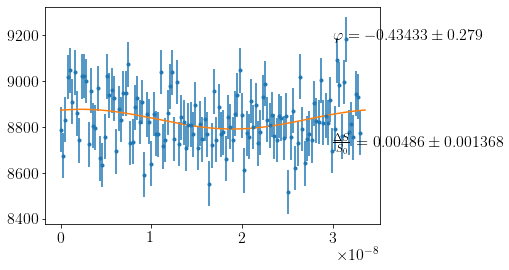

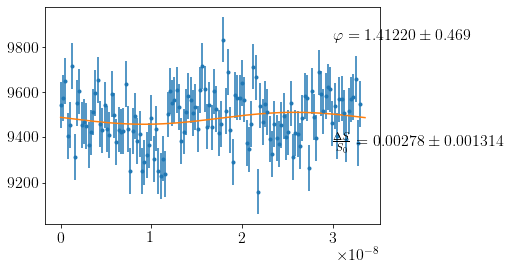

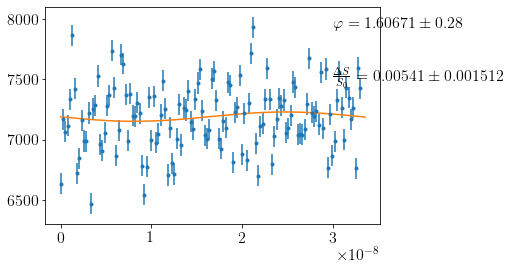

In [11]:
# plot fitu vcetne errorbaru
# my_dpi = 150
# siz = 100
# sizex = 16*siz
# sizey = 9*siz
# plot techto fitu
time_fit = np.linspace(0, t_scale.max(), 200)

for i in range(fotkor_shape[1]):
    
    fotkor_fit = fit_func( [S_0[i],DeltaS[i],x[2,i]], Omega, time_fit)
    
    plt.figure()
    plt.errorbar(t_scale[:fotkor_shape[0]-2],fotkor[:fotkor_shape[0]-2,i],yerr=hist_sigma[i],fmt='.')
    plt.plot(time_fit, fotkor_fit)
    text = r'$\frac{\Delta S}{S_0}  = \,\,$' + r'${:.5f} \pm {:.6f}$'.format(DeltaS_S_ratio[i], Delta_S_S_ratio_sigma[i])
    plt.text(3e-8, fotkor[:,i].max()-500,text) 
    text2 = r'$\varphi  = {:.5f} \pm {:.3}$'.format(fot_phi[i], sigmas[2,i])
    plt.text(3e-8, fotkor[:,i].max(),text2) 


ok

## Urceni $\beta$ + nejistoty

In [12]:
# parametry vypoctu beta

decay_rate = 2*np.pi * 21.008e6  # decay rate dle tabulek NISTu
laser_detun = -32e6 * 2*np.pi  # detuning 
laser_detun_sigma = 4e6 * 2*np.pi # sigma detun

Vyuzijeme nelinearniho sireni chyb. Tedy
\begin{equation}
    \mathcal{\Sigma}^\beta = \mathcal{J}^\beta \mathcal{\Sigma} \mathcal{J }^{\beta \rm T}
\end{equation}

Jakobian $\mathcal{J}^\beta$ vyjadrime pomoci jakobianu $\mathcal{J}^g$, kde $F(\beta, \frac{\Delta S}{S_0}, \Omega, \Delta)=0$, coz je rovnice, kterou resime numericky.

In [13]:
# numericke reseni deltaS/S -> beta

from scipy.optimize import fsolve
from scipy.special import j0, j1

def get_A(decay_rate, detun):
    # returns driven oscillator amplitude in point given by detun param.
    return 1 / 2 * (decay_rate / 2 - detun * 1j) / (detun ** 2 + (decay_rate / 2) ** 2)

def fl_signal(beta, laser_detun, Omega, decay_rate):
    # function calculates deltaS/S0 photon-correlation signal
    # input: beta, laser detuning, RF drive freq, decay rate
    A_minus = get_A(decay_rate, laser_detun - Omega)
    A_plus = get_A(decay_rate, laser_detun + Omega)
    A = get_A(decay_rate, laser_detun)

    numer = 2 * j0(beta) * j1(beta) * np.abs(np.conj(A) * A_plus - A * np.conj(A_minus))
    denom = j0(beta) ** 2 * np.abs(A) ** 2 + j1(beta) ** 2 * (np.abs(A_plus) ** 2 + np.abs(A_minus) ** 2)

    return numer / denom

def get_beta(Omega, decay_rate, laser_detun, norm_mod_amp):
    # function calculates the corresponding beta for given known parameters
    # input: drive frequency, decay_rate, laser detuning, normalized modulation amplitude given by ph_corr_signal
    # output: float value of beta
    def root_func(beta, laser_detun, Omega, decay_rate, norm_mod_amp):
        return fl_signal(beta, laser_detun, Omega, decay_rate) - norm_mod_amp

    sol = fsolve(root_func, np.array([0.01]), args=(laser_detun, Omega, decay_rate, norm_mod_amp), full_output=1)
    return float(sol[0])

In [14]:
from scipy.optimize import approx_fprime, check_grad

def root_func(x):
    [beta, norm_mod_amp, Omega, laser_detun, decay_rate] = x
    return fl_signal(beta, laser_detun, Omega, decay_rate) - norm_mod_amp

def root_func_grad(x):
#     [beta, norm_mod_amp, Omega, laser_detun, decay_rate] = x
    epsilon = 5e-6
    return( approx_fprime(x, root_func, x*epsilon ) )

In [15]:
from scipy.optimize import approx_fprime, check_grad

# get beta
beta = np.zeros(fotkor_shape[1])
beta_sigma = np.zeros(fotkor_shape[1])
for k in range(fotkor_shape[1]):
    beta[k] = get_beta(Omega, decay_rate, laser_detun, DeltaS_S_ratio[k])
    
    # get sigma beta
    jacob_F = root_func_grad( np.array([beta[k], DeltaS_S_ratio[k], Omega, laser_detun, decay_rate]) ) 
    # [dF/dbeta, dF/ddeltaS/S, dF/dOmega, dF/dDelta, dF/dGamma]
    
    # variance-cov parametru
    Sigma_param = np.diag([Delta_S_S_ratio_sigma[k]**2, Omega_sigma**2, laser_detun_sigma**2])
    
    beta_sigma[k] = np.sqrt( jacob_F[0]**-2 * jacob_F[1:-1] @ Sigma_param @ np.transpose( jacob_F[1:-1] ) )
    
    

In [18]:
print(beta)
print(beta_sigma)

[0.00169899 0.00097146 0.00189031]
[0.00047876 0.00045954 0.00052928]


In [19]:
print(beta *1e3)
print(beta_sigma *1e3)

[1.69898785 0.97145662 1.89031262]
[0.47876409 0.45954493 0.52927821]


In [20]:
jacob_F[2]**2  * Omega_sigma**2

2.8283619261084747e-09

In [21]:
check_grad(root_func, root_func_grad,
           np.array([beta[0], DeltaS_S_ratio[0], Omega, laser_detun, decay_rate]))

4.005727246491093e-10

In [22]:
jacob_F[1:-1] @ Sigma_param @ np.transpose( jacob_F[1:-1] )

2.29070486915478e-06

In [23]:
root_func_grad(np.array([beta[0], DeltaS_S_ratio[0], Omega, laser_detun, decay_rate]))

array([ 2.85958317e+00, -1.00000000e+00,  2.68848352e-11,  1.21515512e-12,
       -3.65961698e-11])

## projekce indexu $\beta$ do os $x,y$

In [24]:
# definice funkci, ktere prepocitavaji prumety beta_z,beta_xz,beta_xy do os x,y,z

# korekce funkce vracejici prumety beta pro svazek xy mirici lib. smerem
def get_beta_xyz_phi_xyz_Sxy_z_proj(variables):
    # input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma, a, c]
    #       fot_phi = [phi_z, phi_xz, phi_xy]
    # jednotkovy vektor svazku Sxy = [a,b,c]

    # output: beta_xyz = [beta_x, beta_y, beta_z]
    
    #### overeno
    beta = variables[:3]
    fot_phi = variables[3:6]
    gamma = variables[6]
    a = variables[7]
    c = variables[8]
    b = -np.sqrt(1 - c**2 - a**2)  # zde pozor na znamenko, je treba ho zadat rucne
    
    beta_x_comp = 1 / np.sin(gamma) * (
                beta[1] * np.exp(1j * fot_phi[1]) - beta[0] * np.cos(gamma) * np.exp(1j * fot_phi[0]))
    beta_y_comp = 1 / b * ( beta[2] * np.exp(1j * fot_phi[2]) - a*beta_x_comp - c*beta[0]*np.exp(1j * fot_phi[0]) )

    return (np.array([np.abs(beta_x_comp), np.abs(beta_y_comp)]),
            np.array([np.angle(beta_x_comp), np.angle(beta_y_comp)])
            )

def get_beta_x(variables):
    #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
    #       fot_phi = [phi_z, phi_xz, phi_xy]
    beta = variables[:3]
    fot_phi = variables[3:6]
    gamma = variables[6]
    a = variables[7]
    c = variables[8]
    b = -np.sqrt(1 - c**2 - a**2)  # zde pozor na znamenko, je treba ho zadat rucne
    
    beta_x_comp = 1/np.sin(gamma) * (beta[1]*np.exp(1j*fot_phi[1]) - beta[0]*np.cos(gamma)*np.exp(1j*fot_phi[0]) )
    return( np.abs(beta_x_comp) )

def get_phi_x(variables):
    #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
    #       fot_phi = [phi_z, phi_xz, phi_xy]
    beta = variables[:3]
    fot_phi = variables[3:6]
    gamma = variables[6]
    a = variables[7]
    c = variables[8]
    b = -np.sqrt(1 - c**2 - a**2)  # zde pozor na znamenko, je treba ho zadat rucne
    
    beta_x_comp = 1/np.sin(gamma) * (beta[1]*np.exp(1j*fot_phi[1]) - beta[0]*np.cos(gamma)*np.exp(1j*fot_phi[0]) )
    return( np.angle(beta_x_comp) )

def get_beta_y(variables):
    #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
    #       fot_phi = [phi_z, phi_xz, phi_xy]
    beta = variables[:3]
    fot_phi = variables[3:6]
    gamma = variables[6]
    a = variables[7]
    c = variables[8]
    b = -np.sqrt(1 - c**2 - a**2)  # zde pozor na znamenko, je treba ho zadat rucne
    
    beta_x_comp = 1 / np.sin(gamma) * (
                beta[1] * np.exp(1j * fot_phi[1]) - beta[0] * np.cos(gamma) * np.exp(1j * fot_phi[0]))
    beta_y_comp = 1 / b * ( beta[2] * np.exp(1j * fot_phi[2]) - a*beta_x_comp - c*beta[0]*np.exp(1j * fot_phi[0]) )

    return( np.abs(beta_y_comp) )

def get_phi_y(variables):
    #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
    #       fot_phi = [phi_z, phi_xz, phi_xy]
    beta = variables[:3]
    fot_phi = variables[3:6]
    gamma = variables[6]
    a = variables[7]
    c = variables[8]
    b = -np.sqrt(1 - c**2 - a**2)  # zde pozor na znamenko, je treba ho zadat rucne
    
    beta_x_comp = 1 / np.sin(gamma) * (
                beta[1] * np.exp(1j * fot_phi[1]) - beta[0] * np.cos(gamma) * np.exp(1j * fot_phi[0]))
    beta_y_comp = 1 / b * ( beta[2] * np.exp(1j * fot_phi[2]) - a*beta_x_comp - c*beta[0]*np.exp(1j * fot_phi[0]) )

    
    return( np.angle(beta_y_comp) )

def get_beta_xyz_phi_xyz(variables):
    #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
    #       fot_phi = [phi_z, phi_xz, phi_xy]
    
    # output: beta_xyz = [beta_x, beta_y, beta_z]
    beta = variables[:3]
    fot_phi = variables[3:6]
    gamma = variables[6]
    epsilon = variables[7]
    
    beta_x_comp = 1/np.sin(gamma) * (beta[1]*np.exp(1j*fot_phi[1]) - beta[0]*np.cos(gamma)*np.exp(1j*fot_phi[0]) )
    beta_y_comp = 1/np.cos(epsilon) * ( np.sin(epsilon) * beta_x_comp  - beta[2]*np.exp(1j*fot_phi[2]) )
    
    return(np.array( [np.abs(beta_x_comp), np.abs(beta_y_comp)]), 
           np.array( [np.angle(beta_x_comp), np.angle(beta_y_comp) ] ) 
          ) 


# def get_beta_x(variables):
#     #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
#     #       fot_phi = [phi_z, phi_xz, phi_xy]
#     beta = variables[:3]
#     fot_phi = variables[3:6]
#     gamma = variables[6]
#     epsilon = variables[7]
    
#     beta_x_comp = 1/np.sin(gamma) * (beta[1]*np.exp(1j*fot_phi[1]) - beta[0]*np.cos(gamma)*np.exp(1j*fot_phi[0]) )
#     return( np.abs(beta_x_comp) )

# def get_phi_x(variables):
#     #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
#     #       fot_phi = [phi_z, phi_xz, phi_xy]
#     beta = variables[:3]
#     fot_phi = variables[3:6]
#     gamma = variables[6]
#     epsilon = variables[7]
    
#     beta_x_comp = 1/np.sin(gamma) * (beta[1]*np.exp(1j*fot_phi[1]) - beta[0]*np.cos(gamma)*np.exp(1j*fot_phi[0]) )
#     return( np.angle(beta_x_comp) )

# def get_beta_y(variables):
#     #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
#     #       fot_phi = [phi_z, phi_xz, phi_xy]
#     beta = variables[:3]
#     fot_phi = variables[3:6]
#     gamma = variables[6]
#     epsilon = variables[7]
    
#     beta_x_comp = 1/np.sin(gamma) * (beta[1]*np.exp(1j*fot_phi[1]) - beta[0]*np.cos(gamma)*np.exp(1j*fot_phi[0]) )
#     beta_y_comp = 1/np.cos(epsilon) * ( np.sin(epsilon) * beta_x_comp  - beta[2]*np.exp(1j*fot_phi[2]) )
    
#     return( np.abs(beta_y_comp) )

# def get_phi_y(variables):
#     #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
#     #       fot_phi = [phi_z, phi_xz, phi_xy]
#     beta = variables[:3]
#     fot_phi = variables[3:6]
#     gamma = variables[6]
#     epsilon = variables[7]
    
#     beta_x_comp = 1/np.sin(gamma) * (beta[1]*np.exp(1j*fot_phi[1]) - beta[0]*np.cos(gamma)*np.exp(1j*fot_phi[0]) )
#     beta_y_comp = 1/np.cos(epsilon) * ( np.sin(epsilon) * beta_x_comp  - beta[2]*np.exp(1j*fot_phi[2]) )
    
#     return( np.angle(beta_y_comp) )

def get_beta_x_jac(variables):
    #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
    #       fot_phi = [phi_z, phi_xz, phi_xy]
    # output: grad beta_x
    epsi_err = 1e-8
    return( approx_fprime(variables, get_beta_x, epsi_err) )

def get_beta_y_jac(variables):
    #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
    #       fot_phi = [phi_z, phi_xz, phi_xy]
    # output: grad beta_x
    epsi_err = 1e-8
    return( approx_fprime(variables, get_beta_y, epsi_err) )

def get_phi_x_jac(variables):
    #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
    #       fot_phi = [phi_z, phi_xz, phi_xy]
    # output: grad beta_x
    epsi_err = 1e-8
    return( approx_fprime(variables, get_phi_x, epsi_err) )

def get_phi_y_jac(variables):
    #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
    #       fot_phi = [phi_z, phi_xz, phi_xy]
    # output: grad beta_x
    epsi_err = 1e-8
    return( approx_fprime(variables, get_phi_y, epsi_err) )

def get_beta_x_y_phi_x_y_jacob(variables):
    #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
    #       fot_phi = [phi_z, phi_xz, phi_xy]
    # output: jacobian 
    
    return( np.array([ get_beta_x_jac(variables), get_beta_y_jac(variables), 
                      get_phi_x_jac(variables), get_phi_y_jac(variables) ])
          )
  

In [25]:
get_beta_xyz_phi_xyz([beta[0],beta[1],beta[2], fot_phi[0],fot_phi[1],fot_phi[2], np.pi/4, 21/180 * np.pi])

(array([0.00245865, 0.00130326]), array([ 2.13958807, -1.91161231]))

In [26]:
# get_beta_xyz_phi_xyz_Sxy_z_proj([beta[0],beta[1],0.003, fot_phi[0],fot_phi[1],0, np.pi/4, 0.3572, -0.0722])
get_beta_xyz_phi_xyz_Sxy_z_proj([beta[0],beta[1],0.003, fot_phi[0],fot_phi[1],0, np.pi/4, 0.3583679, 0])

(array([0.00245865, 0.00380577]), array([2.13958807, 2.93109892]))

In [27]:
check_grad(get_phi_y, get_phi_y_jac, [beta[0],beta[1],0.003, fot_phi[0],fot_phi[1],0, np.pi/4, 0.3583679, 0])

8.023854248254295e-05

Prepocitam bety a phi na do os $x,y,z$

In [28]:
## uhly detekcnich svazku
gamma = 45.07/180 * np.pi
gamma_sigma = 6/180 * np.pi
# epsilon = 20/180 * np.pi
# epsilon_sigma = 1/180 * np.pi
Sxy_vec = np.array([85, -230, -20]) / np.sqrt(85**2 + 230**2 + 20**2)

a = Sxy_vec[0]
a_sigma = 0.02
c = Sxy_vec[2]
c_sigma = 0.008


In [52]:
[beta_x_y, phi_x_y] = get_beta_xyz_phi_xyz_Sxy_z_proj( [beta[0],beta[1],beta[2], fot_phi[0],fot_phi[1],fot_phi[2],gamma, a, c] )
beta_xyz = np.append(beta_x_y, beta[0]) # [beta_x, beta_y, beta_z]
phi_xyz = np.append(phi_x_y, fot_phi[0]) # [phi_x, phi_y, phi_z]

#--- nejistoty zakonem sireni chyb
# sirim kovariancni matici diag( sigma^2 beta, sigma^2 phi, simga^2 gamma, epsilon_sigma^2)

# sigma_params = np.diag([beta_sigma[0]**2, beta_sigma[1]**2, 8e-4**2, fot_phi_sigma[0]**2, fot_phi_sigma[1]**2, 
#                         0.1**2, gamma_sigma**2, epsilon_sigma**2 ])

sigma_params = np.diag([beta_sigma[0]**2, beta_sigma[1]**2, beta_sigma[2]**2, fot_phi_sigma[0]**2, fot_phi_sigma[1]**2, 
                        fot_phi_sigma[2]**2, gamma_sigma**2, a_sigma**2, c_sigma**2 ])

jacob_beta_phi_xy = get_beta_x_y_phi_x_y_jacob([beta[0],beta[1],beta[2], fot_phi[0],fot_phi[1],fot_phi[2],gamma, a, c])

sigma_beta_phi_xy = jacob_beta_phi_xy @ sigma_params @ np.transpose(jacob_beta_phi_xy)

beta_xyz_sigma = np.sqrt( np.diag(sigma_beta_phi_xy)[:2] )
phi_xyz_sigma = np.sqrt( np.diag(sigma_beta_phi_xy)[2:] )

beta_xyz_sigma = np.append(beta_xyz_sigma, beta_sigma[0])
phi_xyz_sigma = np.append(phi_xyz_sigma, fot_phi_sigma[0])

print(beta_xyz)
print(beta_xyz_sigma)
print(phi_xyz)
print(phi_xyz_sigma)

[0.0024539  0.00131455 0.00169899]
[0.00090002 0.000654   0.00047876]
[ 2.13913353 -2.00207164 -0.43432661]
[0.32896304 0.5090634  0.27949718]


In [53]:
print(beta_xyz*1e3)
print(beta_xyz_sigma*1e3)
print(phi_xyz)
print(phi_xyz_sigma)

[2.45389854 1.31454725 1.69898785]
[0.90001679 0.6540026  0.47876409]
[ 2.13913353 -2.00207164 -0.43432661]
[0.32896304 0.5090634  0.27949718]


In [30]:
np.sqrt( np.diagonal(sigma_beta_phi_xy) )

array([0.00090002, 0.000654  , 0.32896304, 0.5090634 ])

In [31]:
jacob_beta_phi_xy

array([[ 8.40850755e-01,  1.05543166e+00,  0.00000000e+00,
        -9.11924442e-04,  9.11924486e-04,  0.00000000e+00,
        -3.87999901e-03,  0.00000000e+00,  0.00000000e+00],
       [-1.38944136e-03, -5.02720686e-01,  9.55017858e-01,
         7.74088931e-04,  1.36567970e-04, -9.10656923e-04,
         4.91001944e-04, -8.99395944e-04, -1.16724273e-04],
       [ 2.18731090e+02, -3.82540129e+02,  0.00000000e+00,
         5.82173332e-01,  4.17826707e-01,  0.00000000e+00,
        -3.72531872e-01,  0.00000000e+00,  0.00000000e+00],
       [-3.46596677e+02, -1.06942657e+02,  3.66472852e+02,
        -1.79682935e-03, -3.71513043e-01,  1.37330982e+00,
         1.05659308e+00, -1.67977463e+00,  1.38245695e+00]])

## transformace do soustavy $(xyz)^{\prime}$

In [32]:
def get_beta_xyz_prime(variables):
    beta_complex_xyz = variables[:3] * np.exp(1j*variables[3:6])
    return(  np.abs( 1/np.sqrt(2) * np.array( [ [1,-1,0], [1,1,0], [0,0,np.sqrt(2)] ] ) @ beta_complex_xyz ) )

def get_phi_xyz_prime(variables):
    beta_complex_xyz = variables[:3] * np.exp(1j*variables[3:6])
    return(  np.angle( 1/np.sqrt(2) * np.array( [ [1,-1,0], [1,1,0], [0,0,np.sqrt(2)] ] ) @ beta_complex_xyz ) )

def get_beta_x_prime(variables):
    #input: variables: = [beta_x, beta_y , betaz, phi_x, phi_y, phi_z]
    beta_complex_xyz = variables[:3] * np.exp(1j*variables[3:6])
    return(  np.abs( 1/np.sqrt(2) * np.array( [ [1,-1,0], [1,1,0], [0,0,np.sqrt(2)] ] ) @ beta_complex_xyz )[0] )  

def get_phi_x_prime(variables):
    #input: variables: = [beta_x, beta_y , betaz, phi_x, phi_y, phi_z]
    beta_complex_xyz = variables[:3] * np.exp(1j*variables[3:6])
    return(  np.angle( 1/np.sqrt(2) * np.array( [ [1,-1,0], [1,1,0], [0,0,np.sqrt(2)] ] ) @ beta_complex_xyz )[0] )

def get_beta_y_prime(variables):
    #input: variables: = [beta_x, beta_y , betaz, phi_x, phi_y, phi_z]
    beta_complex_xyz = variables[:3] * np.exp(1j*variables[3:6])
    return(  np.abs( 1/np.sqrt(2) * np.array( [ [1,-1,0], [1,1,0], [0,0,np.sqrt(2)] ] ) @ beta_complex_xyz )[1] )  

def get_phi_y_prime(variables):
    #input: variables: = [beta_x, beta_y , betaz, phi_x, phi_y, phi_z]
    beta_complex_xyz = variables[:3] * np.exp(1j*variables[3:6])
    return(  np.angle( 1/np.sqrt(2) * np.array( [ [1,-1,0], [1,1,0], [0,0,np.sqrt(2)] ] ) @ beta_complex_xyz )[1] )

def get_beta_z_prime(variables):
    #input: variables: = [beta_x, beta_y , betaz, phi_x, phi_y, phi_z]
    beta_complex_xyz = variables[:3] * np.exp(1j*variables[3:6])
    return(  np.abs( 1/np.sqrt(2) * np.array( [ [1,-1,0], [1,1,0], [0,0,np.sqrt(2)] ] ) @ beta_complex_xyz )[2] )  

def get_phi_z_prime(variables):
    #input: variables: = [beta_x, beta_y , betaz, phi_x, phi_y, phi_z]
    beta_complex_xyz = variables[:3] * np.exp(1j*variables[3:6])
    return(  np.angle( 1/np.sqrt(2) * np.array( [ [1,-1,0], [1,1,0], [0,0,np.sqrt(2)] ] ) @ beta_complex_xyz )[2] )

def get_beta_x_prime_jac(variables):
    #input: variables: = [beta_x, beta_y , betaz, phi_x, phi_y, phi_z]
    
    epsi_err = 1e-8
    return( approx_fprime(variables, get_beta_x_prime, epsi_err) )

def get_phi_x_prime_jac(variables):
    #input: variables: = [beta_x, beta_y , betaz, phi_x, phi_y, phi_z]
    
    epsi_err = 1e-8
    return( approx_fprime(variables, get_phi_x_prime, epsi_err) ) 
           
def get_beta_y_prime_jac(variables):
    #input: variables: = [beta_x, beta_y , betaz, phi_x, phi_y, phi_z]
    
    epsi_err = 1e-8
    return( approx_fprime(variables, get_beta_y_prime, epsi_err) )

def get_phi_y_prime_jac(variables):
    #input: variables: = [beta_x, beta_y , betaz, phi_x, phi_y, phi_z]
    
    epsi_err = 1e-8
    return( approx_fprime(variables, get_phi_y_prime, epsi_err) )
           
def get_beta_z_prime_jac(variables):
    #input: variables: = [beta_x, beta_y , betaz, phi_x, phi_y, phi_z]
    
    epsi_err = 1e-8
    return( approx_fprime(variables, get_beta_z_prime, epsi_err) )

def get_phi_z_prime_jac(variables):
    #input: variables: = [beta_x, beta_y , betaz, phi_x, phi_y, phi_z]
    
    epsi_err = 1e-8
    return( approx_fprime(variables, get_phi_z_prime, epsi_err) )

def get_beta_x_y_phi_x_y_prime_jacob(variables):
    #input: beta = [beta_z, beta_xz, beta_xy]  variables = [beta, fot_phi, gamma]
    #       fot_phi = [phi_z, phi_xz, phi_xy]
    # output: jacobian 
    
    return( np.array([ get_beta_x_prime_jac(variables), get_beta_y_prime_jac(variables), get_beta_z_prime_jac(variables),
                      get_phi_x_prime_jac(variables), get_phi_y_prime_jac(variables),
                     get_phi_z_prime_jac(variables)])
          )

funkce transformuji beta do jine soustavy dle matice transformace

jednotlive slozky maji amplitydy a faze:

In [33]:
beta_xyz_prime = get_beta_xyz_prime(np.array( [beta_xyz[0],beta_xyz[1],beta_xyz[2], phi_xyz[0], phi_xyz[1], phi_xyz[2] ] ))
beta_xyz_prime

array([0.00237039, 0.00145976, 0.00169899])

In [34]:
phi_xyz_prime = get_phi_xyz_prime(np.array( [beta_xyz[0],beta_xyz[1],beta_xyz[2], phi_xyz[0], phi_xyz[1], phi_xyz[2] ] ))
phi_xyz_prime

array([ 1.80294439,  2.70445616, -0.43432661])

sireni nejistot: jacobian bude vypadat takto: $R \cdot \partial b_i /\partial \rm params $

In [35]:
# jacobian
# jacob_xyz_xyz_prime = trans_xyz_xyz_prime @ np.array( [ [np.exp(1j*phi_xyz[0]), 0, 0, 1j*beta_xyz[0]* np.exp(1j*phi_xyz[0]), 0, 0],
#             [0, np.exp(1j*phi_xyz[1]), 0, 0, 1j*beta_xyz[1]* np.exp(1j*phi_xyz[1]), 0],
#             [0, 0, np.exp(1j*phi_xyz[2]), 0, 0, 1j*beta_xyz[2]* np.exp(1j*phi_xyz[2])]
#           ] )
# jacob_xyz_xyz_prime

jacob_xyz_xyz_prime = get_beta_x_y_phi_x_y_prime_jacob(np.array( [beta_xyz[0],beta_xyz[1],beta_xyz[2], phi_xyz[0], phi_xyz[1], phi_xyz[2] ] ))
print( DataFrame(jacob_xyz_xyz_prime) )

            0           1    2         3         4    5
0    0.667522    0.557122  0.0 -0.000572  0.000572  0.0
1    0.597093   -0.004143  0.0  0.000930 -0.000930  0.0
2    0.000000    0.000000  1.0  0.000000  0.000000  0.0
3   98.409052 -183.702748  0.0  0.691038  0.308962  0.0
4 -259.486788  484.392536  0.0  1.003732 -0.003732  0.0
5    0.000000    0.000000  0.0  0.000000  0.000000  1.0


In [36]:
sigma_beta_phi_xy_trans = np.zeros((6,6))

sigma_beta_phi_xy_trans[:2,:2] = sigma_beta_phi_xy[:2,:2]
sigma_beta_phi_xy_trans[2,2] = beta_xyz_sigma[2]**2
sigma_beta_phi_xy_trans[0, 3:5] = sigma_beta_phi_xy[0,2:4]
sigma_beta_phi_xy_trans[1, 3:5] = sigma_beta_phi_xy[1,2:4]
sigma_beta_phi_xy_trans[3, 3:5] = sigma_beta_phi_xy[2,2:4]
sigma_beta_phi_xy_trans[4, 3:5] = sigma_beta_phi_xy[3,2:4]
sigma_beta_phi_xy_trans[5,5] = phi_xyz_sigma[2]**2

for i in range(6):
    for k in range(i):
        sigma_beta_phi_xy_trans[i,k] = sigma_beta_phi_xy_trans[k,i]
        
print( DataFrame(sigma_beta_phi_xy_trans) )
print( DataFrame(sigma_beta_phi_xy) )

              0             1             2         3         4         5
0  8.100302e-07 -1.609979e-07  0.000000e+00  0.000015 -0.000210  0.000000
1 -1.609979e-07  4.277194e-07  0.000000e+00  0.000086  0.000007  0.000000
2  0.000000e+00  0.000000e+00  2.292151e-07  0.000000  0.000000  0.000000
3  1.496834e-05  8.627571e-05  0.000000e+00  0.108217 -0.047234  0.000000
4 -2.098861e-04  6.556241e-06  0.000000e+00 -0.047234  0.259146  0.000000
5  0.000000e+00  0.000000e+00  0.000000e+00  0.000000  0.000000  0.078119
              0             1         2         3
0  8.100302e-07 -1.609979e-07  0.000015 -0.000210
1 -1.609979e-07  4.277194e-07  0.000086  0.000007
2  1.496834e-05  8.627571e-05  0.108217 -0.047234
3 -2.098861e-04  6.556241e-06 -0.047234  0.259146


In [37]:
# sireni chyb:
sigma_beta_phi_xyz_prime = jacob_xyz_xyz_prime @ sigma_beta_phi_xy_trans @ np.transpose( jacob_xyz_xyz_prime ) 

In [38]:
beta_xyz_prime_sigma = np.sqrt( np.diag(sigma_beta_phi_xyz_prime)[:3] ) 
phi_xyz_prime_sigma = np.sqrt(  np.diag(sigma_beta_phi_xyz_prime)[3:6] ) 

In [49]:
print(beta_xyz_prime)
print(beta_xyz_prime_sigma)
print(phi_xyz_prime)
print(phi_xyz_prime_sigma)

[0.00237039 0.00145976 0.00169899]
[0.00055008 0.00096829 0.00047876]
[ 1.80294439  2.70445616 -0.43432661]
[0.22576323 0.61678513 0.27949718]


In [50]:
print(beta_xyz)
print(phi_xyz)

[0.0024539  0.00131455 0.00169899]
[ 2.13913353 -2.00207164 -0.43432661]


In [40]:
np.sqrt( np.diag(sigma_beta_phi_xyz_prime)[3:-1])

array([0.22576323, 0.61678513])

In [41]:
sigma_beta_phi_xyz_prime

array([[ 3.02591553e-07,  1.27167330e-07,  0.00000000e+00,
         6.72490347e-06, -7.35547459e-05,  0.00000000e+00],
       [ 1.27167330e-07,  9.37586136e-07,  0.00000000e+00,
         5.16668460e-05, -3.62664783e-05,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.29215053e-07,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 6.72490347e-06,  5.16668460e-05,  0.00000000e+00,
         5.09690356e-02,  1.57971936e-02,  0.00000000e+00],
       [-7.35547459e-05, -3.62664783e-05,  0.00000000e+00,
         1.57971936e-02,  3.80423901e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  7.81186758e-02]])

## sedi, ok, ale neuvazuju korelaci mezi beta_z a phi_z, takze neni to idealka

## vypocet elektrickeho pole

In [45]:
# dalsi parametry
m = 40 * 1.66053904e-27 # calcium mass
k_vec = 2*np.pi * 1/(396.847e-9) # wave vector
e = 1.60217662e-19 # elem charge

In [46]:
# get E-fields
E_rf = (m*Omega**2 / (k_vec*e)) * beta_xyz
E_rf_sigma = np.sqrt( (beta_xyz_sigma*m*Omega**2 / (k_vec*e))**2 + (2*m*Omega / (k_vec*e) * beta_xyz * Omega_sigma)**2  ) # propagase chyb

print(E_rf)
print(E_rf_sigma)
m*Omega**2/(e*k_vec) * beta_xyz_sigma

[2.28934365 1.22639561 1.58505618]
[0.8407698  0.61058338 0.44765583]


array([0.83966296, 0.61014613, 0.44665886])

jak velkou roli hraje nejistota omega?

In [47]:
beta_xyz**2 / Omega**2 * Omega_sigma**2 / beta_xyz_sigma**2

array([0.00065953, 0.00035844, 0.00111728])

In [48]:
## v soustave xyz prime:
# get E-fields
E_rf_prime = (m*Omega**2 / (k_vec*e)) * beta_xyz_prime
E_rf_prime_sigma = np.sqrt( (beta_xyz_prime_sigma*m*Omega**2 / (k_vec*e))**2 + (2*m*Omega / (k_vec*e) * beta_xyz_prime * Omega_sigma)**2  ) # propagase chyb

print(E_rf_prime)
print(E_rf_prime_sigma)

[2.21143856 1.36186638 1.58505618]
[0.51488357 0.9037224  0.44765583]


vidim, ze desetina procenta prislusi nejistote omega

# Odhad freq. posuvu

## Doppler shift

In [54]:
c = 299792458 # rychlost svetla

doppler_2nd_EMM = - (Omega /(2*c*k_vec))**2 * sum(beta_xyz**2)
print(doppler_2nd_EMM)

-4.2051793635716444e-21


nejistota

In [55]:
jacob_doppler_EMM = - Omega/(2*c**2 * k_vec**2) * np.array( [sum(beta_xyz**2), Omega * beta_xyz[0], 
                                                             Omega* beta_xyz[1], Omega* beta_xyz[2]] )
sigma_doppler_EMM_propagation = np.zeros((4,4))
sigma_doppler_EMM_propagation[0,0] = Omega_sigma**2
sigma_doppler_EMM_propagation[1,1:3] = sigma_beta_phi_xy[0,:2]
sigma_doppler_EMM_propagation[2,1:3] = sigma_beta_phi_xy[1,:2]
sigma_doppler_EMM_propagation[3,3] = beta_xyz_sigma[2]**2

DataFrame(jacob_doppler_EMM)
print( DataFrame(sigma_doppler_EMM_propagation) )
DataFrame(sigma_beta_phi_xy)

              0             1             2             3
0  3.161086e+12  0.000000e+00  0.000000e+00  0.000000e+00
1  0.000000e+00  8.100302e-07 -1.609979e-07  0.000000e+00
2  0.000000e+00 -1.609979e-07  4.277194e-07  0.000000e+00
3  0.000000e+00  0.000000e+00  0.000000e+00  2.292151e-07


,0,1,2,3
0,8.100302e-07,-1.609979e-07,0.000015,-0.000210
1,-1.609979e-07,4.277194e-07,0.000086,0.000007
2,1.496834e-05,8.627571e-05,0.108217,-0.047234
3,-2.098861e-04,6.556241e-06,-0.047234,0.259146


In [56]:
doppler_2nd_EMM_sigma = np.sqrt( jacob_doppler_EMM @ sigma_doppler_EMM_propagation @ np.transpose(jacob_doppler_EMM) )
doppler_2nd_EMM_sigma

1.81175320552997e-21

In [59]:
## prispevek sekularniho pohybu a IMM
k_B = 1.38064852e-23
T_d = 0.5e-3 # teplota iontu
T_sigma = T_d # nejistota teploty

doppler_2nd_sec_IMM = - 5/2 * k_B /(m*c**2) * T_d
doppler_2nd_sec_IMM_sigma = 5/2 * k_B /(m*c**2) * T_sigma

print(doppler_2nd_sec_IMM)
print(doppler_2nd_sec_IMM_sigma)

-2.8909638228987856e-18
2.8909638228987856e-18


In [60]:
# celkovy doppler shift
doppler_2nd = doppler_2nd_EMM + doppler_2nd_sec_IMM
doppler_2nd_sigma = np.sqrt( doppler_2nd_EMM_sigma**2 + doppler_2nd_sec_IMM_sigma**2 )

print(doppler_2nd)
print(doppler_2nd_sigma)

-2.895169002262357e-18
2.8909643906072657e-18


## Stark shift

In [65]:
alpha = -7.2677e-40
alpha_sigma = 0.0021e-40
h = 6.62607004e-34
f_0 = 411042129776401.7
f_0_sigma = 1.1

stark_2nd_EMM = -0.5 * alpha * m**2 * Omega**4 / ( h * f_0 * 2*e**2 * k_vec**2) * sum(beta_xyz**2)
print(stark_2nd_EMM)

6.175759969086883e-21


In [69]:
## nejistota:
jacob_stark_EMM = m**2 * Omega**3 /(e**2 *h *k_vec**2 * f_0) * np.array( [-alpha *sum(beta_xyz**2), -0.5*alpha * Omega * beta_xyz[0],
                                                                          -0.5*alpha * Omega * beta_xyz[1],  -0.5*alpha * Omega * beta_xyz[2],
                                                                         -Omega/4 * sum(beta_xyz**2), alpha * Omega * sum(beta_xyz**2)/ (4*f_0) ] )

# paramtry: omega, beta_x, beta_y, beta_z, alpha, f_0

sigma_stark_EMM_propagation = np.zeros((6,6))
sigma_stark_EMM_propagation[0,0] = Omega_sigma**2
sigma_stark_EMM_propagation[1,1:3] = sigma_beta_phi_xy[0,:2]
sigma_stark_EMM_propagation[2,1:3] = sigma_beta_phi_xy[1,:2]
sigma_stark_EMM_propagation[3,3] = beta_xyz_sigma[2]**2
sigma_stark_EMM_propagation[4,4] = alpha_sigma**2
sigma_stark_EMM_propagation[5,5] = f_0_sigma**2

DataFrame(jacob_stark_EMM)
print( DataFrame(sigma_stark_EMM_propagation) )
DataFrame(sigma_beta_phi_xy)

              0             1             2             3             4     5
0  3.161086e+12  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.00
1  0.000000e+00  8.100302e-07 -1.609979e-07  0.000000e+00  0.000000e+00  0.00
2  0.000000e+00 -1.609979e-07  4.277194e-07  0.000000e+00  0.000000e+00  0.00
3  0.000000e+00  0.000000e+00  0.000000e+00  2.292151e-07  0.000000e+00  0.00
4  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  4.410000e-86  0.00
5  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  1.21


,0,1,2,3
0,8.100302e-07,-1.609979e-07,0.000015,-0.000210
1,-1.609979e-07,4.277194e-07,0.000086,0.000007
2,1.496834e-05,8.627571e-05,0.108217,-0.047234
3,-2.098861e-04,6.556241e-06,-0.047234,0.259146


In [74]:
# sedi s mathematikou
stark_2nd_EMM_sigma = np.sqrt( jacob_stark_EMM @ sigma_stark_EMM_propagation @ np.transpose(jacob_stark_EMM) )
stark_2nd_EMM_sigma

2.668375367408088e-21

In [75]:
## prispevek sekularniho pohybu a IMM
stark_2nd_sec_IMM = -0.5 * alpha * m * Omega**2 / (h*f_0 * e**2) * 2 * k_B * T_d
stark_2nd_sec_IMM

1.6982770156441172e-18

In [77]:
jacob_stark_sec_IMM = (m*k_B*Omega)/(e**2 *h * f_0) * np.array([-2*T_d * alpha, -T_d*Omega, T_d*Omega * alpha / f_0, -alpha*Omega])

#parametry: omega, alpha, f_0, T
sigma_stark_sec_IMM_propagation = np.zeros((4,4) )
sigma_stark_sec_IMM_propagation[0,0] = Omega_sigma**2
sigma_stark_sec_IMM_propagation[1,1] = alpha_sigma**2
sigma_stark_sec_IMM_propagation[2,2] = f_0_sigma**2
sigma_stark_sec_IMM_propagation[3,3] = T_sigma **2

stark_2nd_sec_IMM_sigma = np.sqrt( jacob_stark_sec_IMM @ sigma_stark_sec_IMM_propagation @ np.transpose(jacob_stark_sec_IMM) )
stark_2nd_sec_IMM_sigma

1.6985784037233093e-18

In [78]:
# celkovy stark shift
stark_2nd = stark_2nd_EMM + stark_2nd_sec_IMM
stark_2nd_sigma = np.sqrt( stark_2nd_EMM_sigma**2 + stark_2nd_sec_IMM_sigma**2 )

print(stark_2nd)
print(stark_2nd_sigma)

1.704452775613204e-18
1.6985804996591497e-18


## kombinace obou shiftu

In [79]:
motional_shift = stark_2nd + doppler_2nd
motional_shift_sigma = np.sqrt(stark_2nd_sigma**2 + doppler_2nd_sigma**2)

motional_shift_EMM = stark_2nd_EMM + doppler_2nd_EMM
motional_shift_EMM_sigma = np.sqrt(stark_2nd_EMM_sigma**2 + doppler_2nd_EMM_sigma**2)

print(motional_shift)
print(motional_shift_sigma)

print(motional_shift_EMM)
print(motional_shift_EMM_sigma)

-1.190716226649153e-18
3.353036060286493e-18
1.9705806055152382e-21
3.225318089605794e-21
